<a href="https://colab.research.google.com/github/Dienert/reviews_analyzer/blob/main/notebooks/4%20-%20CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Reference:

https://github.com/dipanjanS/nlp_workshop_odsc_europe20/blob/master/notebooks/Module_03_NLP%20Applications%20-%20Machine%20and%20Deep%20Learning/12_NLP_Applications_Text_Classification_Deep_Learning_CNN_Models.ipynb

# Text Classification - Deep Learning CNN Models

In [31]:
!pip install contractions
!pip install textsearch
!pip install tqdm
import nltk
nltk.download('punkt')

     |████████████████████████████████| 106 kB 6.8 MB/s 
     |████████████████████████████████| 284 kB 42.6 MB/s 
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [32]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)

In [ ]:
tf.config.list_physical_devices('GPU')

## Load Movie Review Dataset

In [36]:
label_type = 'final_label'

In [38]:
# datasets_path = f'../dataset/{label_type}/'
datasets_path = '.'

Current folder: /content
Scrip dataset download: False


In [39]:
# %%skip $skip_download_dataset
!curl -L https://raw.githubusercontent.com/Dienert/reviews_analyzer/main/dataset/final_label/train.csv > train.csv
!curl -L https://raw.githubusercontent.com/Dienert/reviews_analyzer/main/dataset/final_label/val.csv > val.csv
!curl -L https://raw.githubusercontent.com/Dienert/reviews_analyzer/main/dataset/final_label/test.csv > test.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  946k  100  946k    0     0   9.9M      0 --:--:-- --:--:-- --:--:-- 10.0M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  138k  100  138k    0     0  2137k      0 --:--:-- --:--:-- --:--:-- 2137k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  150k  100  150k    0     0  2216k      0 --:--:-- --:--:-- --:--:-- 2216k


### Prepare Train Test Split

In [40]:
import pandas as pd

In [41]:
train = pd.read_csv(f'{datasets_path}/train.csv')
train

,x,y
0,Four Stars. thought provoking,1
1,Not What I Expected. Although a few of the sto...,0
2,Outliers - Gladwell - A Good Tour of the Outer...,1
3,Surprisingly good..... .. Interesting connecti...,1
4,Success. Good book to read for success,2
...,...,...
3420,Thoughts on Gladwell's Outliers: An exceptiona...,2
3421,Spellbinding. I haven't read other Gladwell bo...,2
3422,Very Thought Provoking. Excellent book. This b...,2
3423,Very Interesting and Well Done. This book help...,1


In [77]:
train.y.value_counts()

2    1520
1    1231
0     674
Name: y, dtype: int64

In [154]:
train_sentiments = train.y.map({0: 'negative', 1:'negative', 2:'positive'})

In [155]:
train_sentiments.value_counts()

negative    1905
positive    1520
Name: y, dtype: int64

In [156]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
x_resampled, y_resampled = rus.fit_resample(train.x.values.reshape(-1,1), train_sentiments)

In [157]:
x_resampled

array([["Great Read. Would recommend.. Similar writing to his other works. I've really enjoyed the way he thinks."],
       ['Very interestings concepts. The ideas were very new and thought provoking. Some were logical and some were a surprise.'],
       ['All In Education Should Read This. This book should be an interesting read for anyone, but I particularly want to highlight the need for all educators to read it. Current educational policy needs a whack on the side of the head. (I write this as an experienced teacher neck deep in No Child Left Behind, and the policy makers\' forcing "research based strategies" into our lesson plans.) Do I think the research that Gladwell cites somehow trumps current mainstream educational research? Not necessarily. But it does give the reader a chance to pull their head out of today\'s pervasive educational group think and consider alternatives.'],
       ...,
       ['Spellbinding. I haven\'t read other Gladwell books but from what I\'ve heard, he\

In [158]:
x_resampled.shape

(3040, 1)

In [159]:
train_reviews = pd.Series(x_resampled.reshape(-1,))
train_reviews

0       Great Read. Would recommend.. Similar writing ...
1       Very interestings concepts. The ideas were ver...
2       All In Education Should Read This. This book s...
3       Worthy Read: Gladwell's Intent. No, it [excell...
4       Pretty good read.. Overall this is a pretty go...
                              ...                        
3035    Insightful, knowledgable and fun.. Brilliant b...
3036    Thoughts on Gladwell's Outliers: An exceptiona...
3037    Spellbinding. I haven't read other Gladwell bo...
3038    Very Thought Provoking. Excellent book. This b...
3039    Seeing the forest instead of the trees. Life i...
Length: 3040, dtype: object

In [166]:
train_sentiments = pd.Series(y_resampled)

In [167]:
train_sentiments.value_counts()

negative    1520
positive    1520
Name: y, dtype: int64

In [168]:
train_sentiments = train_sentiments.values

In [169]:
val = pd.read_csv(f'{datasets_path}/val.csv')
val

,x,y
0,A great read and worth every penny!. My first ...,2
1,"Senior English. Dear Mr. Gladwell,  am a seni...",1
2,Outliers - Gladwell - A Good Tour of the Outer...,1
3,Five Stars. I like Malcolm Gladwell books.,2
4,A Different Perspective on the Nature of Succe...,2
...,...,...
537,Worth the money. page quality is good but its ...,1
538,Absolute Genius. This is the first book I read...,2
539,Excellent book. Outliers is an intriguing book...,2
540,Another article turned into a book. This is ye...,0


In [171]:
test_reviews = test.x
test_sentiments = test.y.map({0: 'negative', 1:'negative', 2:'positive'})
test_sentiments.value_counts()

negative    302
positive    240
Name: y, dtype: int64

In [ ]:
test = pd.read_csv(f'{datasets_path}/test.csv')
test

,x,y
0,A great read and worth every penny!. My first ...,2
1,"Senior English. Dear Mr. Gladwell,  am a seni...",1
2,Outliers - Gladwell - A Good Tour of the Outer...,1
3,Five Stars. I like Malcolm Gladwell books.,2
4,A Different Perspective on the Nature of Succe...,2
...,...,...
537,Worth the money. page quality is good but its ...,1
538,Absolute Genius. This is the first book I read...,2
539,Excellent book. Outliers is an intriguing book...,2
540,Another article turned into a book. This is ye...,0


In [ ]:
test_reviews = test.x
test_sentiments = test.y.map({0: 'negative', 1:'negative', 2:'positive'})
test_sentiments.value_counts()

negative    302
positive    240
Name: y, dtype: int64

In [172]:
test_sentiments = test_sentiments.values

# Text Wrangling & Normalization

In [174]:
import contractions
from bs4 import BeautifulSoup
import numpy as np
import re
import tqdm
import unicodedata


def strip_html_tags(text):
  soup = BeautifulSoup(text, "html.parser")
  [s.extract() for s in soup(['iframe', 'script'])]
  stripped_text = soup.get_text()
  stripped_text = re.sub(r'[\r|\n|\r\n]+', '\n', stripped_text)
  return stripped_text

def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

def pre_process_corpus(docs):
  norm_docs = []
  for doc in tqdm.tqdm(docs):
    doc = strip_html_tags(doc)
    doc = doc.translate(doc.maketrans("\n\t\r", "   "))
    doc = doc.lower()
    doc = remove_accented_chars(doc)
    doc = contractions.fix(doc)
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = re.sub(' +', ' ', doc)
    doc = doc.strip()  
    norm_docs.append(doc)
  
  return norm_docs

In [175]:
%%time

norm_train_reviews = pre_process_corpus(train_reviews)
norm_test_reviews = pre_process_corpus(test_reviews)

100%|██████████| 542/542 [00:00<00:00, 4740.46it/s]

CPU times: user 733 ms, sys: 51.9 ms, total: 785 ms
Wall time: 769 ms


## Preprocessing

To prepare text data for our deep learning model, we transform each review into a sequence.
Every word in the review is mapped to an integer index and thus the sentence turns into a sequence of numbers.

To perform this transformation, keras provides the ```Tokenizer```

In [176]:
t = Tokenizer(oov_token='<UNK>')
# fit the tokenizer on the documents
t.fit_on_texts(norm_train_reviews)
t.word_index['<PAD>'] = 0

In [177]:
max([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), min([(k, v) for k, v in t.word_index.items()], key = lambda x:x[1]), t.word_index['<UNK>']

(('unfairly', 7566), ('<PAD>', 0), 1)

In [178]:
train_sequences = t.texts_to_sequences(norm_train_reviews)

In [179]:
test_sequences = t.texts_to_sequences(norm_test_reviews)

In [180]:
print("Vocabulary size={}".format(len(t.word_index)))
print("Number of Documents={}".format(t.document_count))

Vocabulary size=7567
Number of Documents=3040


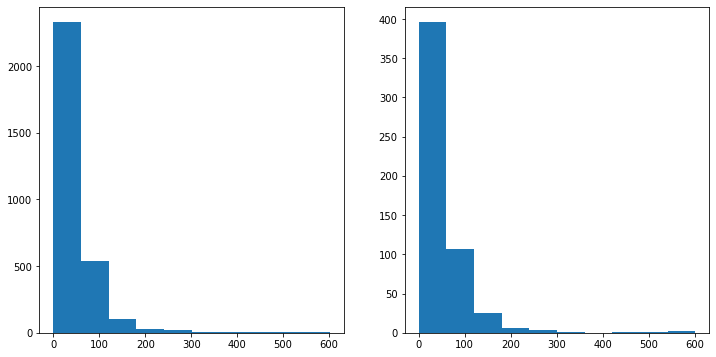

In [181]:
import matplotlib.pyplot as plt
%matplotlib inline

train_lens = [len(s) for s in train_sequences]
test_lens = [len(s) for s in test_sequences]

fig, ax = plt.subplots(1,2, figsize=(12, 6))
h1 = ax[0].hist(train_lens)
h2 = ax[1].hist(test_lens)

### Sequence Normalization

Not all reviews are of same length. To handle this difference in length of reviews, we define a maximum length.
For reviews which are smaller than this length, we pad them with zeros which longer ones are truncated

In [182]:
MAX_SEQUENCE_LENGTH = 1000

In [183]:
# pad dataset to a maximum review length in words
X_train = sequence.pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_test = sequence.pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)
X_train.shape, X_test.shape

((3040, 1000), (542, 1000))

### Encoding Labels

The dataset contains labels of the form positive/negative. The following step encodes the labels using ```sklearn's``` ```LabelEncoder```

In [184]:
le = LabelEncoder()
num_classes=2 # positive -> 1, negative -> 0

In [185]:
y_train = le.fit_transform(train_sentiments)
y_test = le.transform(test_sentiments)

In [186]:
VOCAB_SIZE = len(t.word_index)

## Prepare the Model

Since textual data is a sequence of words, we utilize ```1D``` convolutions to scan through the sentences.
The model first transforms each word into lower dimensional embedding/vector space followed by 1d convolutions and then passing the data through dense layers before the final layer for classification

In [190]:
EMBED_SIZE = 300
EPOCHS=2
BATCH_SIZE=128

In [191]:
# create the model
model = Sequential()
model.add(Embedding(VOCAB_SIZE, EMBED_SIZE, input_length=MAX_SEQUENCE_LENGTH))
model.add(Conv1D(filters=128, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=64, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=4, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1000, 300)         2270100   
                                                                 
 conv1d_12 (Conv1D)          (None, 1000, 128)         153728    
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 500, 128)         0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 500, 64)           32832     
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 250, 64)          0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 250, 32)          

## Model Training

In [192]:
# Fit the model
model.fit(X_train, y_train, 
          validation_split=0.1,
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          verbose=1)

Epoch 1/2
22/22 [==============================] - 5s 180ms/step - loss: 0.6800 - accuracy: 0.5662 - val_loss: 0.8252 - val_accuracy: 0.3191
Epoch 2/2
22/22 [==============================] - 3s 138ms/step - loss: 0.5808 - accuracy: 0.6955 - val_loss: 0.3010 - val_accuracy: 0.9276


## Model Evaluation

In [193]:
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

17/17 [==============================] - 0s 18ms/step - loss: 0.5919 - accuracy: 0.6679
Accuracy: 66.79%


In [194]:
predictions = model.predict(X_test).ravel()
predictions[:10]

array([0.7468613 , 0.00459759, 0.18045904, 0.8682155 , 0.6396132 ,
       0.862567  , 0.8675707 , 0.56838876, 0.7706477 , 0.10236917],
      dtype=float32)

In [195]:
predictions = ['positive' if item >= .5 else 'negative' for item in predictions]
predictions[:10]

['positive',
 'negative',
 'negative',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'positive',
 'negative']

In [196]:
from sklearn.metrics import confusion_matrix, classification_report

labels = ['negative', 'positive']
print(classification_report(test_sentiments, predictions))
pd.DataFrame(confusion_matrix(test_sentiments, predictions), index=labels, columns=labels)

              precision    recall  f1-score   support

    negative       0.90      0.46      0.61       302
    positive       0.58      0.93      0.71       240

    accuracy                           0.67       542
   macro avg       0.74      0.70      0.66       542
weighted avg       0.75      0.67      0.65       542



,negative,positive
negative,138,164
positive,16,224
